In [1]:
%matplotlib widget

from tqdm import trange

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self, n_neurons=16, n_layers=4):
        super(Net, self).__init__()
        
        self.seq = torch.nn.Sequential()

        n_inputs = 2
        for i in range(n_layers):
            self.seq.add_module(f"lin_{i}", nn.Linear(n_inputs, n_neurons))
            n_inputs = n_neurons
            self.seq.add_module(f"tanh_{i}", nn.Tanh())
        
        self.seq.add_module(f"lin_{i+1}", nn.Linear(n_inputs, 1))
        
        for module in self.seq:
            if isinstance(module, nn.Linear):
                torch.nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out', nonlinearity='tanh')
        
    def forward(self, x,t):        
        return self.seq(torch.cat([x, t], axis=1)) 


In [11]:
# equation parameters
A = .5 # initial displacment[mm]
sigma = 2. # std of initial push [mm]
c = 1 # shear wave speed [mm/ms]
eta = 0. # viscocity []

# Optimisation parameters
x_interval = [-20., 20.] #[mm]
t_interval = [0., 20.] #[ms]
ic_samples = 200
bc_samples = 100
xt_samples = 500

# init conditions
x_ic = torch.tensor(np.random.uniform(*x_interval, (ic_samples, 1)), device=device, dtype=torch.float)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
u_ic = A * torch.exp(-0.5 * (x_ic / sigma) ** 2)

# boundary conditions
x_bc = torch.tensor(np.random.choice(x_interval, (bc_samples, 1)), dtype=torch.float)
t_bc = torch.tensor(np.random.uniform(*t_interval, x_bc.size()), device=device, dtype=torch.float).requires_grad_(True)
u_bc = torch.zeros_like(x_bc)

pinn = Net(n_neurons=8)
pinn = pinn.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

# # pretraining
# losses = []
# for epoch in (pbar := trange(1000)):
    
#     # resample points each n epochs
#     if not epoch % 50:
#         x_samples = torch.tensor(np.random.uniform(*x_interval, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
#         t_samples = torch.tensor(np.random.uniform(*t_interval, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)

#     # pde loss
#     net_out = net(x_samples, t_samples)
    
#     net_out_u_x = torch.autograd.grad(net_out, x_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]
#     net_out_u_t = torch.autograd.grad(net_out, t_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]
    
#     net_out_u_xx = torch.autograd.grad(net_out_u_x, x_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]
#     net_out_u_tt = torch.autograd.grad(net_out_u_t, t_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]
    
#     loss_pde = loss_fn(net_out_u_xx - (c**2 + eta * net_out_u_t) * net_out_u_tt, torch.zeros(net_out.size()))
#     losses.append(loss_pde.item())
    
#     loss_pde.backward()
#     optimizer.step()
#     optimizer.zero_grad()
    
#     if not epoch % 10:
#         pbar.set_description(f"Loss={loss_pde.item():.3e}")


losses = [[], [], []]
for epoch in (pbar := trange(50000)):
    
    # resample points each n epochs
    if not epoch % 1000:
        x_samples = torch.tensor(np.random.uniform(*x_interval, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
        t_samples = torch.tensor(np.random.uniform(*t_interval, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)

    # init conditions
    pred_ic = pinn(x_ic, t_ic)
    pred_u_t_ic = torch.autograd.grad(pred_ic, t_ic, grad_outputs=torch.ones(pred_ic.shape), create_graph=True)[0]
    loss_u_ic = loss_fn(pred_ic, u_ic)
    loss_u_t_ic = loss_fn(pred_u_t_ic, torch.zeros(pred_ic.shape))
    
    # pde loss
    pred_u = pinn(x_samples, t_samples)
    
    pred_u_x = torch.autograd.grad(pred_u, x_samples, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
    pred_u_t = torch.autograd.grad(pred_u, t_samples, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
    
    pred_u_xx = torch.autograd.grad(pred_u_x, x_samples, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
    pred_u_tt = torch.autograd.grad(pred_u_t, t_samples, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
    
    # with viscocity
    loss_pde = loss_fn(pred_u_xx - (c**2 + eta * pred_u_t) * pred_u_tt, torch.zeros(pred_u.size()))
    
    # Combining the loss functions
    loss = 1e0 * loss_u_ic + 1e0 * loss_u_t_ic + 1e0 * loss_pde 

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses[0].append(loss_u_ic.item())
    losses[1].append(loss_u_t_ic.item())
    losses[2].append(loss_pde.item())
    
    if not epoch % 10:
        pbar.set_description(f"Loss={loss.item():.3e}")


Loss=1.194e-06: 100%|██████████| 50000/50000 [02:14<00:00, 372.39it/s]


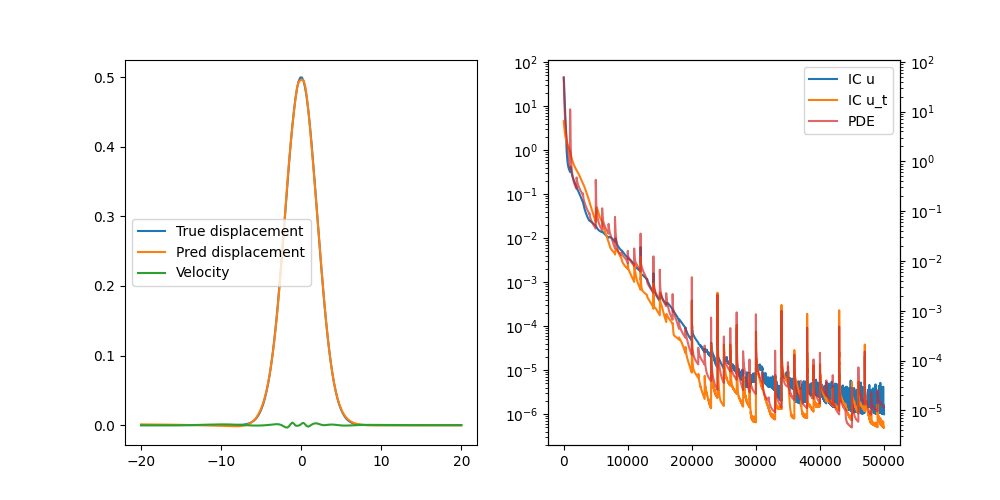

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
twinx_1 = axes[1].twinx()

x_ic = torch.linspace(*x_interval, 200, device=device, dtype=torch.float).view(-1, 1).requires_grad_(True)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
pred_u_ic = pinn(x_ic, t_ic)
pred_u_t_ic = torch.autograd.grad(pred_u_ic, t_ic, grad_outputs=torch.ones_like(pred_u_ic), create_graph=True)[0]
true_u_ic = A * torch.exp(-0.5 * (torch.linspace(*x_interval, 200) / sigma) ** 2)

axes[0].plot(np.linspace(*x_interval, 200), true_u_ic.cpu().detach(), label='True displacement')
axes[0].plot(np.linspace(*x_interval, 200), pred_u_ic.cpu().detach(), label='Pred displacement')
axes[0].plot(np.linspace(*x_interval, 200), pred_u_t_ic.cpu().detach(), label='Velocity')
axes[0].legend()

ln1 = axes[1].plot(losses[0], label='IC u')
ln2 = axes[1].plot(losses[1], label='IC u_t')
axes[1].set_yscale('log')
ln4 = twinx_1.plot(losses[2], c='C3', alpha=.7, label='PDE')
twinx_1.set_yscale('log')

lns = ln1 + ln2 + ln4
labs = [l.get_label() for l in lns]
axes[1].legend(lns, labs, loc=0)

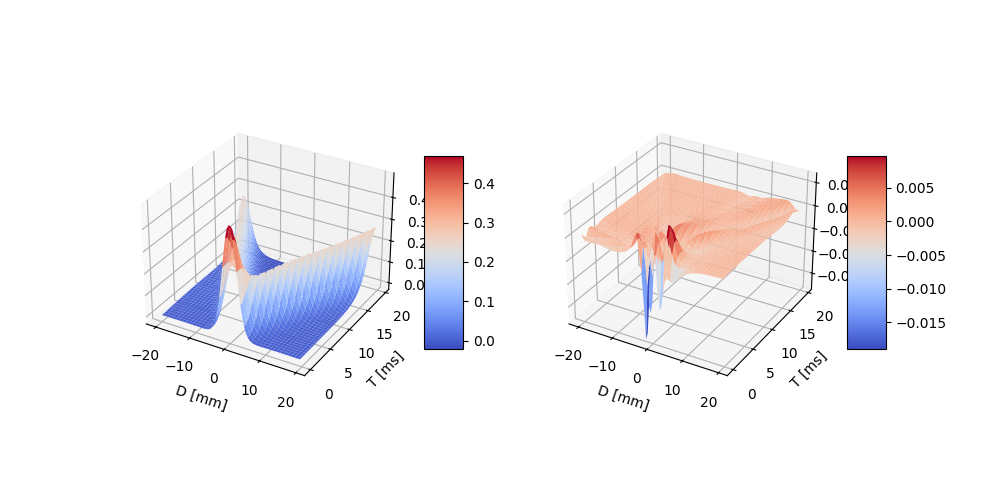

In [12]:
from matplotlib import cm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

x = np.arange(*x_interval, 0.5)
t = np.arange(*t_interval, 0.5)
mg_x, mg_t = np.meshgrid(x, t, indexing='ij')

pt_x = torch.from_numpy(mg_x.reshape((-1, 1))).float().to(device).requires_grad_(True)
pt_t = torch.from_numpy(mg_t.reshape((-1, 1))).float().to(device).requires_grad_(True)

pred_u = pinn(pt_x, pt_t).cpu()

pred_u_x = torch.autograd.grad(pred_u, pt_x, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
pred_u_t = torch.autograd.grad(pred_u, pt_t, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]

pred_u_xx = torch.autograd.grad(pred_u_x, pt_x, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
pred_u_tt = torch.autograd.grad(pred_u_t, pt_t, grad_outputs=torch.ones(pred_u.size()), create_graph=True)[0]
pde_loss = pred_u_xx - (c**2 + eta * pred_u_t) * pred_u_tt

pred_u = pred_u.detach().numpy().reshape(mg_x.shape)
pde_loss = pde_loss.detach().numpy().reshape(mg_x.shape)

surf = axes[0].plot_surface(mg_x, mg_t, pred_u, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)

surf = axes[1].plot_surface(mg_x, mg_t, pde_loss, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)

axes[0].set(xlabel='D [mm]', ylabel='T [ms]')
axes[1].set(xlabel='D [mm]', ylabel='T [ms]')
plt.show()